# GEN ALL

*This notebook is intended to be used as a generator of adversarial examples using all five methods.*

## Structure

- Imports
- Global settings
  - Max norm, size of max-norm ball in which I seek for adversarial examples
    - 50 / 255
  - Model that is used
    - MnistCnnPatt
  - batch_size - number of benign examples
    - 10 for testing, 1000 for real application
- Functions that create adversarial examples given benign examples
  - In batch mode
- Generation mechanism and statistics capture
  - save generated adv. examples as images
  - percentage of success of attack

## Requirements

- Simple parallelization
  - meaning that computation can be split across several jupyter notebooks eventually

# 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

In [3]:
import torch.nn as nn
import torch

In [4]:
from utils import MnistData, Clipper
from models import ModelManager, ModelType
from adversarials import ClassificationAdversarials

In [5]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Gloabal settings

In [6]:
max_norm = 50 / 255

In [7]:
model = ModelManager.get_trained(ModelType.MnistCnnB)

In [28]:
batch_size = 100

In [9]:
data = MnistData(True)

# 2. Functions for adv. examples

### 1. FGSM

In [10]:
def fgsm(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    benign_examples = benign_examples.detach()
    benign_examples.requires_grad = True
    if benign_examples.grad is not None:
        benign_examples.grad.zero_()
    loss = loss_fn(model(benign_examples), labels)
    loss.backward()
    adversarial_examples = benign_examples + max_norm * benign_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)
    return Clipper.clip_for_image(adversarial_examples)

### 2. I-FGSM

In [11]:
def ifgsm(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    adversarial_examples = benign_examples.detach()
    step_size = 1e-2
    for _ in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad:
            adversarial_examples.grad.zero_()
        loss_fn(model(adversarial_examples), labels).backward()
        adversarial_examples = Clipper.clip(
            benign_examples,
            adversarial_examples + step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1),
            max_norm
        )
    return adversarial_examples

### 3. PGD

In [12]:
def pgd(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, max_norm) -> torch.Tensor:
    loss_fn = nn.CrossEntropyLoss()
    adversarial_examples = benign_examples.detach() + 2 * max_norm * (torch.rand((len(labels), 1, 28, 28)) - 0.5)
    step_size = 1e-2
    for _ in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad:
            adversarial_examples.grad.zero_()
        loss_fn(model(adversarial_examples), labels).backward()
        adversarial_examples = Clipper.clip(
            benign_examples,
            adversarial_examples + step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1),
            max_norm
        )
    return adversarial_examples

### 4. L-BFGS

In [13]:
def mnist_batch_linfty_norm(input:torch.Tensor) -> torch.Tensor:
    return torch.max(torch.max(torch.max(torch.abs(input), dim=3)[0], dim=2)[0], dim=1)[0]

def get_adv(model, benign_examples, target_labels, batch_norm_function, c_lambda):
    step_size = 1e-2
    adversarial_examples = (benign_examples + (50 / 255) * ( 2 * torch.rand(benign_examples.shape) - 1)).detach() \
        if batch_norm_function == mnist_batch_linfty_norm \
        else torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        loss =  batch_norm_function(adversarial_examples - benign_examples).sum() \
            + c_lambda * loss_fn(model(adversarial_examples), target_labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
    return adversarial_examples


def lbfgs_batch(model, benign_examples, labels, batch_norm_function):
    batch = len(benign_examples)
    all_adversarial_examples = torch.zeros(batch, 9, 28, 28)
    target_labels = torch.tensor([[i for i in range(10) if i != label] for label in labels])
    for i in range(9):
        print(f'\tTargeted L-BFGS: {i}')
        successful_indexes = []
        unsuccessful_indexes = [i for i in range(batch)]
        c_lambda = 0.01
        while unsuccessful_indexes:
            still_benign_examples = torch.tensor([benign_examples[j].tolist() for j in unsuccessful_indexes])
            still_target_labels = torch.tensor([target_labels[j, i] for j in unsuccessful_indexes])
            adversarial_examples = get_adv(model, still_benign_examples, still_target_labels, batch_norm_function, c)
            adversarial_preds = torch.argmax(model(adversarial_examples), dim=1)
            indexes_to_delete = []
            for j in range(len(adversarial_examples)):
                # print(j)
                if adversarial_preds[j] != labels[unsuccessful_indexes[j]] or c_lambda >= 100:
                    all_adversarial_examples[unsuccessful_indexes[j], i, :, :] = adversarial_examples[j, :, :, :]
                    successful_indexes.append(unsuccessful_indexes[j])
                    indexes_to_delete.append(unsuccessful_indexes[j])
            for j in indexes_to_delete:
                unsuccessful_indexes.remove(j)
            c_lambda *= 10
    expanded_examples = benign_examples.expand(batch, 9, 28, 28)
    diffs = all_adversarial_examples - expanded_examples
    norms = torch.zeros(batch, 9)
    for i in range(9):
        norms[:, i] = batch_norm_function(diffs[:, i, :, :].reshape(batch, 1, 28, 28))
        preds = torch.argmax(model(all_adversarial_examples[:,i,:,:].reshape(batch, 1, 28, 28)), dim=1)
        norms[:, i] += torch.tensor([1e10 if preds[j] == labels[j] else 0 for j in range(batch)])
    selected_adversarial_examples = torch.zeros(benign_examples.shape)
    indexes = torch.argmin(norms, dim=1)
    for i in range(batch):
        selected_adversarial_examples[i, 0, :, :] = all_adversarial_examples[i, indexes[i], :, :]
    return selected_adversarial_examples

### 5. CW

In [18]:
def mnist_batch_linfty_norm(input:torch.Tensor) -> torch.Tensor:
    return torch.max(torch.max(torch.max(torch.abs(input), dim=3)[0], dim=2)[0], dim=1)[0]

def cw_batch(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, c_lambda: float, batch_norm) -> torch.Tensor:
    adversarial_examples = (benign_examples + (50 / 255) * ( 2 * torch.rand(benign_examples.shape) - 1)).detach() \
        if batch_norm == mnist_batch_linfty_norm \
        else torch.zeros(benign_examples.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1e-2
    for _ in range(100):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        loss = batch_norm(adversarial_examples - benign_examples).sum() - c_lambda * loss_fn(model(adversarial_examples), labels)
        loss.backward()
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad.apply_(lambda x: 1 if x >= 0 else -1)).detach()
    return adversarial_examples

# 3. Generation mechanism

In [29]:
benign_examples, labels = data.choose_first_well_classified(batch_size, model)

In [16]:

# Generation
print('Starting FGSM attack')
fgsm_examples = fgsm(model, benign_examples, labels, max_norm)

print('Starting I-FGSM attack')
ifgsm_examples = ifgsm(model, benign_examples, labels, max_norm)

print('Starting PGD attack')
pgd_examples = pgd(model, benign_examples, labels, max_norm)

print('Starting targeted L-BFGS attack')
lbfgs_examples = lbfgs_batch(model, benign_examples, labels, mnist_batch_linfty_norm)

print('Starting CW attack with c_lambda = 1')
cw_examples = cw_batch(model, benign_examples, labels, 1, mnist_batch_linfty_norm)

Starting FGSM attack
Starting I-FGSM attack
Starting PGD attack
Starting targeted L-BFGS attack
	Targeted L-BFGS: 0
	Targeted L-BFGS: 1
	Targeted L-BFGS: 2
	Targeted L-BFGS: 3
	Targeted L-BFGS: 4
	Targeted L-BFGS: 5
	Targeted L-BFGS: 6
	Targeted L-BFGS: 7
	Targeted L-BFGS: 8
Starting CW attack with c_lambda = 1


In [26]:
print('Starting CW attack with c_lambda = 0.01')
cw_examples = cw_batch(model, benign_examples, labels, 0.01, mnist_batch_linfty_norm)

Starting CW attack with c_lambda = 0.01


KeyboardInterrupt: 

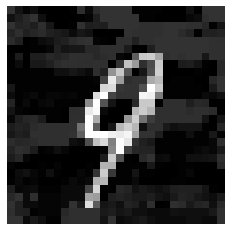

In [17]:

# Save'em all
for i in range(batch_size):
    example = np.array(benign_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\benign_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(fgsm_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\fgsm_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(ifgsm_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\ifgsm_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(pgd_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\pgd_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(lbfgs_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\lbfgs_{i}.png", bbox_inches="tight", pad_inches=0)
    
    example = np.array(cw_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\ALLGEN\\cw_{i}.png", bbox_inches="tight", pad_inches=0)

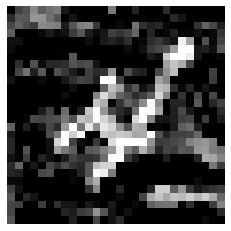

In [27]:
for i in range(batch_size):
    example = np.array(cw_examples[i].detach()).reshape(28, 28)
    plt.imshow(example, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(f"AEXAMPLES\\CW\\cw_{i}.png", bbox_inches="tight", pad_inches=0)

In [21]:

fgsm_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, fgsm_examples)
print(f'fgsm: {len(fgsm_adversarials)}')

ifgsm_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, ifgsm_examples)
print(f'ifgsm: {len(ifgsm_adversarials)}')

pgd_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, pgd_examples)
print(f'pgd: {len(pgd_adversarials)}')

lbfgs_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, lbfgs_examples)
print(f'lbfgs: {len(lbfgs_adversarials)}')

cw_adversarials = ClassificationAdversarials.get_adversarials(model, benign_examples, labels, cw_examples)
print(f'cw: {len(cw_adversarials)}')    

fgsm: 28
ifgsm: 77
pgd: 79
lbfgs: 100
cw: 99


# 4. Ad Hoc